# Validation of the model results
In order to know whether the MIKE 21 simulation gives reasonable results, we can compare the simulation to observation stations. 
This notebook shows the comparison of the surface elevations in single spatial points to:
1. measurements from measurement stations 
2. altimetry data from satellites. 

Before running the notebook, you can choose to create a virtual environment containing the packages used for recreating the results in the notebook. The environment is found in this folder as a .txt file. Make sure to activate the kernel using that virtual environment. 

In [1]:
import mikeio
import modelskill
import matplotlib.pyplot as plt 
import pandas as pd

Instead of reading the entire dfsu (area.dfsu file), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

In [2]:
root = "../"            # Change the root if needed
fldr = f"{root}output/" # Change the folder if needed
data_dir = f"{fldr}points.dfs0"
dfsu_dir = f"{fldr}area.dfsu"

In [ ]:
# Load dfsu to get geometry for plotting
area = mikeio.read(dfsu_dir, time = "2014-01-10")
geom = area.geometry

In [ ]:
# Data is stored as a dfs0 file. We can use mikeio to open the file and look at the content. 
# For more info on mikeio, see https://dhi.github.io/mikeio

# Load data
# The data includes a spin-up period, so we will skip the first 10 days of data
ds = mikeio.read(data_dir, time = slice("2014-01-10", "2023-12-31"))
ds

<mikeio.Dataset>
dims: (time:174863)
time: 2014-01-10 00:00:00 - 2023-12-31 23:00:00 (174863 records)
geometry: GeometryUndefined()
number of items: 39

## Compare to observations of water levels

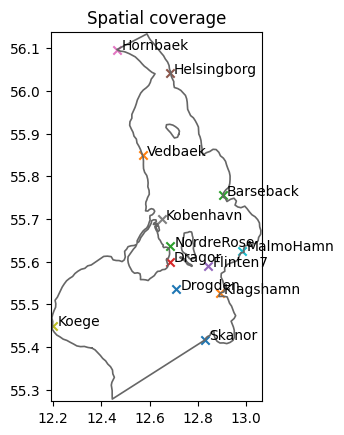

In [5]:
# The modelskill package can be used to compare model results with observations.
# For more info on modelskill, see https://github.com/DHI/modelskill

# Collect observation directories in list
obs_dir = [f"{root}observations/Drogden_2014_2023.csv", 
           f"{root}observations/Klagshamn_2014_2023.csv",
           f"{root}observations/Barseback_2014_2023.csv",
           f"{root}observations/Dragor_2014_2023.csv",
           f"{root}observations/Flinten7_2017_2023.csv",
           f"{root}observations/Helsingborg_2019_2023.csv",
           f"{root}observations/Hornbaek_2014_2023.csv",
           f"{root}observations/Kobenhavn_2014_2023.csv",
           f"{root}observations/Koege_2014_2023.csv",
           f"{root}observations/MalmoHamn_2019_2023.csv",
           f"{root}observations/Skanor_2014_2023.csv",
           f"{root}observations/Vedbaek_2014_2023.csv",
           f"{root}observations/NordreRose_2014_2019.csv"]

# Collect each observation station as point observations in a list
obs = []
cmps = []
stations = []
for i in range(len(obs_dir)):
    obs_df = pd.read_csv(obs_dir[i],index_col=0,parse_dates=True)
    # Define modelskill point observation
    o = modelskill.PointObservation(obs_df, x=obs_df["longitude"].iloc[0], y=obs_df["latitude"].iloc[0],
                                    item="SLEV", name=obs_df["platformId"].iloc[0], 
                                    quantity=modelskill.Quantity(name="Surface Elevation", unit="meter"))
    obs.append(o)
    # Save the coordinates and stations for quick overview (and for plotting)
    stations.append(pd.DataFrame({"Station": [obs_df["platformId"].iloc[0]], 
                    "Longitude": obs_df["longitude"].iloc[0], 
                    "Latitude": obs_df["latitude"].iloc[0]}))

    # Define MIKE 21 data as a model result.
    mr = modelskill.PointModelResult(ds[obs_df["platformId"].iloc[0]+": Surface elevation"], name="MIKE 21")

    # Match the observation and the model result
    cmp = modelskill.match(o, mr)
    # Collect comparers
    cmps.append(cmp.remove_bias())

# Create a comparer collection from the comparers
cc = modelskill.ComparerCollection(cmps)
# Get spatial overview of station locations
modelskill.plotting.spatial_overview(obs, geom)
plt.savefig(f"{root}figures/stations.png", bbox_inches='tight')

In [6]:
# Save dataframe with station coordinates
stations_df = pd.concat(stations,ignore_index=True)
stations_df.to_csv(f"{root}observations/stations.csv",index=False)

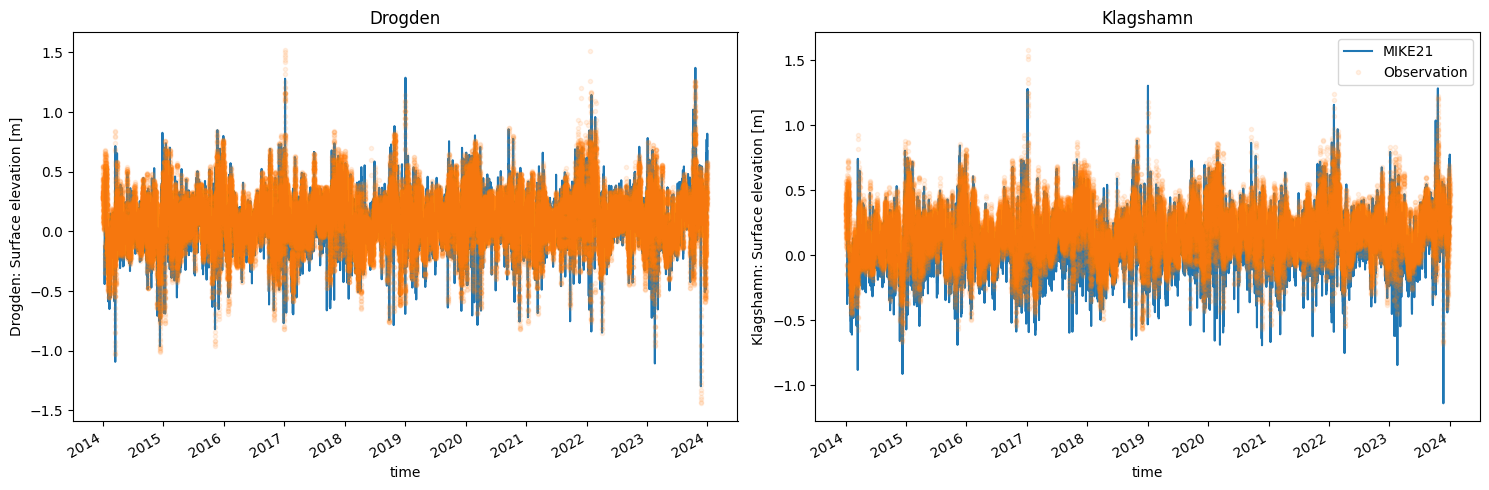

In [7]:
# Plot a time series
fig,axs = plt.subplots(1,2, figsize=(15,5))
for i in range(2):
    (ds[obs[i].name+": Surface elevation"]).plot(ax=axs[i],title=obs[i].name,label="MIKE21")
    axs[i].plot(obs[i].time,obs[i].values, '.', alpha=0.1, label="Observation")
plt.tight_layout();
plt.legend();

In [8]:
# Print skill table
print(cc.skill())

                  n          bias      rmse     urmse       mae        cc  \
observation                                                                 
Drogden      170144 -1.002270e-18  0.068652  0.068652  0.053412  0.940073   
Klagshamn     87400  5.203059e-18  0.064780  0.064780  0.050203  0.944285   
Barseback     87333  1.139042e-18  0.070172  0.070172  0.054649  0.915217   
Dragor       172669 -5.761079e-18  0.065381  0.065381  0.051056  0.909587   
Flinten7      47916 -3.558942e-18  0.072930  0.072930  0.054167  0.870950   
Helsingborg   38092  1.119200e-18  0.074743  0.074743  0.058946  0.919269   
Hornbaek     172239  3.114624e-18  0.097001  0.097001  0.075469  0.927868   
Kobenhavn    164906 -6.592425e-18  0.078208  0.078208  0.060885  0.897574   
Koege        170568 -1.666298e-18  0.078496  0.078496  0.060108  0.938866   
MalmoHamn     31911  1.068787e-17  0.066211  0.066211  0.050326  0.915018   
Skanor        87117 -1.060305e-17  0.074999  0.074999  0.058183  0.949016   

We can see from the skill table that the model has an RMSE of 6.5-9.7 cm. This is good.

<Axes: title={'center': 'Drogden'}, xlabel='time', ylabel='Surface Elevation [meter]'>

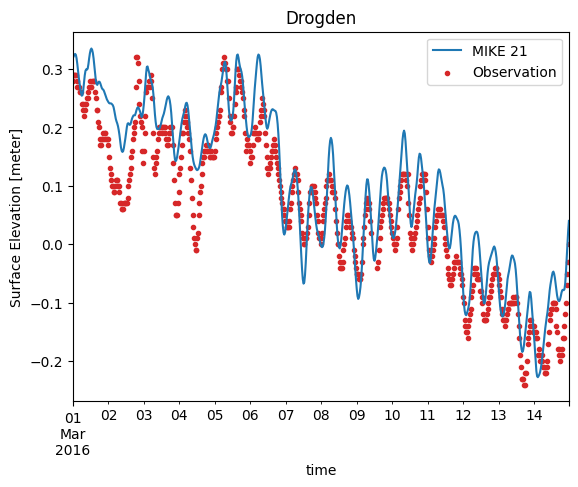

In [9]:
# Look at a timeseries for a qualitative comparison between observations and model
cc["Drogden"].sel(time=slice("2016-03-01","2016-03-14")).plot.timeseries()

In [11]:
# Make scatter plots
# These plots also include the skill table. Plots are saved but not shown, since this is too tedious.. 
# (code takes ~7 mins to run)
for i,cmp in enumerate(cc):
    plt.figure();
    cmp.sel(model="MIKE 21").plot(skill_table=True,figsize=(6,5));
    plt.savefig(f"{root}figures/modelskill_comparison_{cmp.name}.png", bbox_inches='tight');
    plt.close();

c:\Users\frtp\AppData\Local\miniforge3\envs\test_env\Lib\site-packages\modelskill\plotting\_misc.py:83: UserWarning: Showing only 50000 points in plot. Set `include` to True to show all points.
  warnings.warn(
c:\Users\frtp\AppData\Local\miniforge3\envs\test_env\Lib\site-packages\modelskill\plotting\_misc.py:83: UserWarning: Showing only 50000 points in plot. Set `include` to True to show all points.
  warnings.warn(
c:\Users\frtp\AppData\Local\miniforge3\envs\test_env\Lib\site-packages\modelskill\plotting\_misc.py:83: UserWarning: Showing only 50000 points in plot. Set `include` to True to show all points.
  warnings.warn(
c:\Users\frtp\AppData\Local\miniforge3\envs\test_env\Lib\site-packages\modelskill\plotting\_misc.py:83: UserWarning: Showing only 50000 points in plot. Set `include` to True to show all points.
  warnings.warn(
c:\Users\frtp\AppData\Local\miniforge3\envs\test_env\Lib\site-packages\modelskill\plotting\_misc.py:83: UserWarning: Showing only 50000 points in plot. Set 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

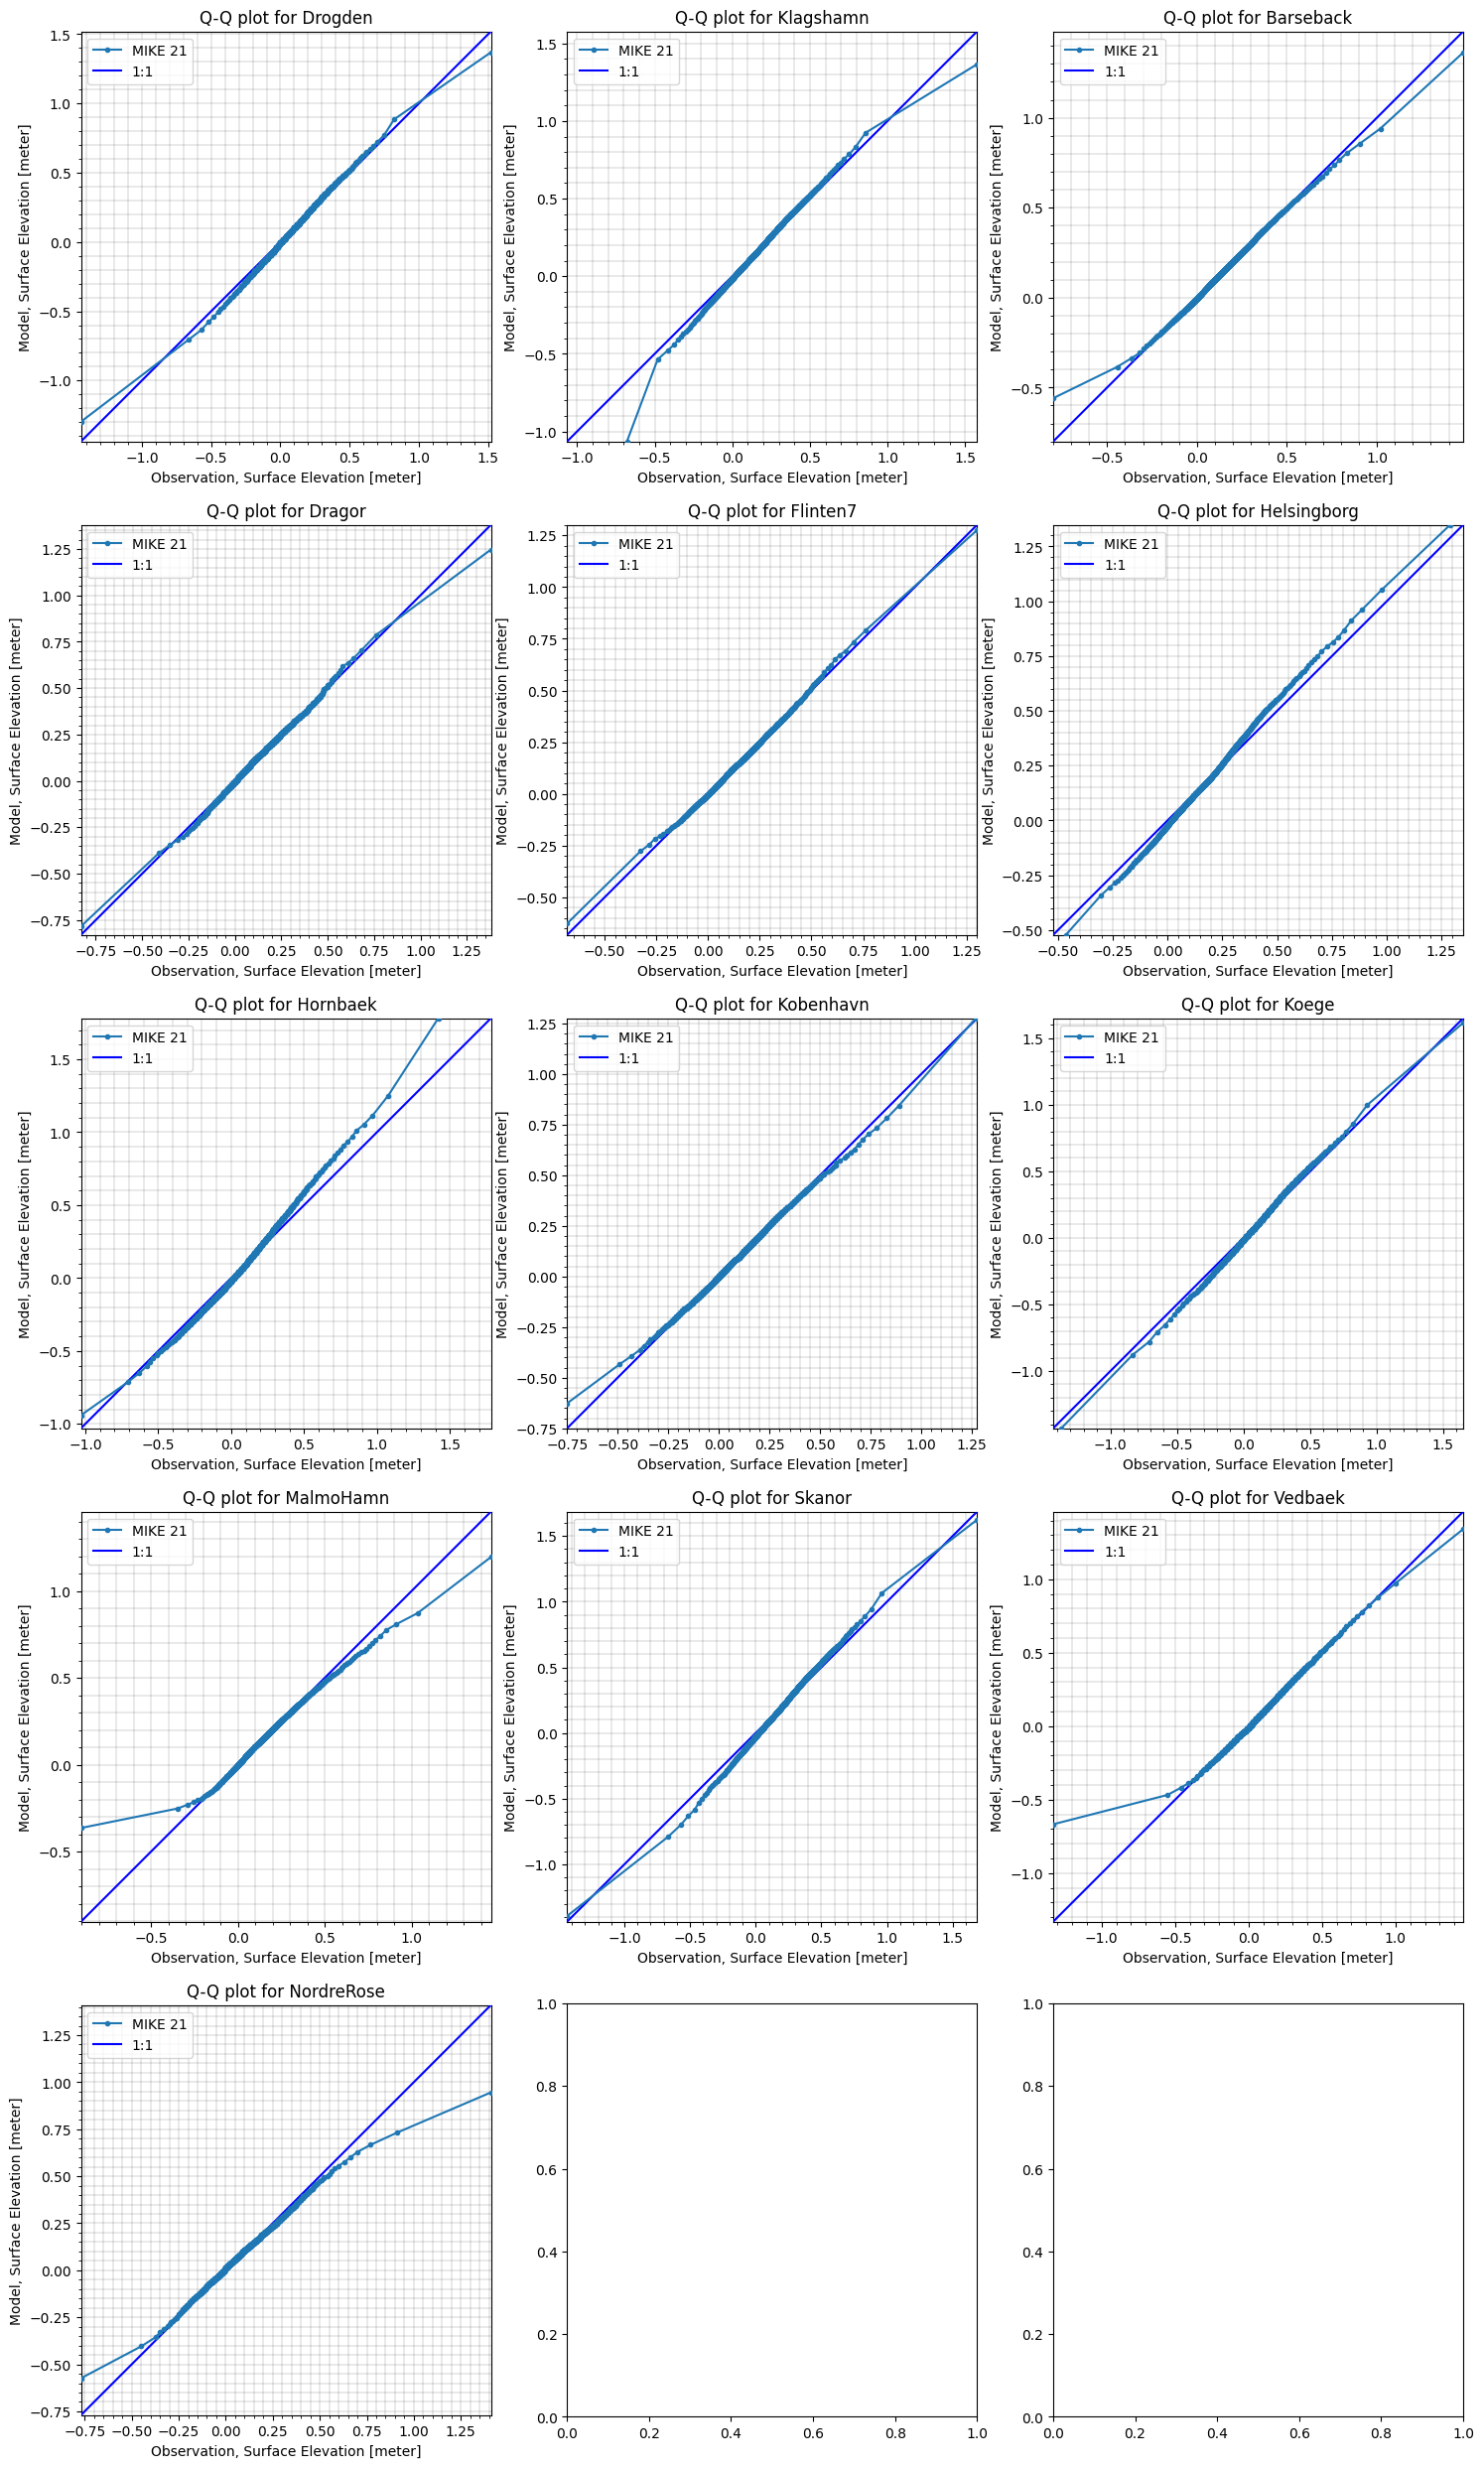

In [12]:
# Make qq plots
# Determine the number of rows and columns for subplots
num_comparers = len(cc)
num_cols = 3  # Reasonable number of columns
num_rows = (num_comparers + num_cols - 1) // num_cols  # Calculate rows needed

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axs array for easy iteration if it's 2D
if num_rows > 1:
    axs = axs.flatten()
for i,cmp in enumerate(cc):
    cmp.plot.qq(ax = axs[i])
plt.tight_layout()
plt.savefig(f"{root}figures/modelskill_comparison_qq.png", bbox_inches='tight')
plt.show()

## Compare to observations of current velocity components


<Axes: title={'center': 'Spatial coverage'}>

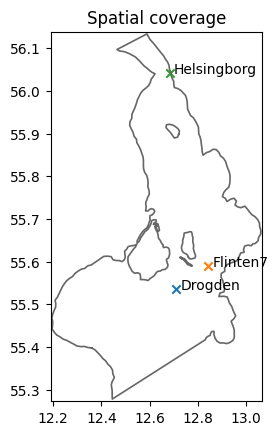

In [19]:
# The modelskill package can be used to compare model results with observations.
# For more info on modelskill, see https://github.com/DHI/modelskill
stations = pd.read_csv(f"{root}observations/stations.csv",index_col=0)

# Collect observation directories in list
obs_dir = [f"{root}observations/Drogden_u_v_2022_2023.csv", 
           f"{root}observations/Flinten7_u_v_2014_2023.csv",
           f"{root}observations/Helsingborg_u_v_2016_2018.csv",]
names = ["Drogden", "Flinten7", "Helsingborg"]
# Collect each observation station as point observations in a list
obs = []
cmps_u = []
cmps_v = []
for i in range(len(obs_dir)):
    obs_df = pd.read_csv(obs_dir[i],index_col=0,parse_dates=True)
    
    # Define modelskill point observation
    o_u = modelskill.PointObservation(obs_df, x=stations.loc[names[i]].Longitude, y=stations.loc[names[i]].Latitude,
                                    item="current u", name=names[i], 
                                    quantity=modelskill.Quantity(name="U velocity", unit="meter per second"))
    o_v = modelskill.PointObservation(obs_df, x=stations.loc[names[i]].Longitude, y=stations.loc[names[i]].Latitude,
                                    item="current v", name=names[i], 
                                    quantity=modelskill.Quantity(name="V velocity", unit="meter per second"))
    obs.append(o_u)

    # Define MIKE 21 data as a model result.
    mr_u = modelskill.PointModelResult(ds[names[i]+": U velocity"], name="MIKE 21")
    mr_v = modelskill.PointModelResult(ds[names[i]+": V velocity"], name="MIKE 21")


    # Match the observation and the model result
    cmp_u = modelskill.match(o_u, mr_u)
    cmp_v = modelskill.match(o_v, mr_v)
    # Collect comparers
    cmps_u.append(cmp_u.remove_bias())
    cmps_v.append(cmp_v.remove_bias())

# Create a comparer collection from the comparers
cc_u = modelskill.ComparerCollection(cmps_u)
cc_v = modelskill.ComparerCollection(cmps_v)
# Get spatial overview of station locations
modelskill.plotting.spatial_overview(obs, geom)

In [6]:
print("\nU velocity: \n",cc_u.skill())
print("\nV velocity: \n",cc_v.skill())


U velocity: 
                   n          bias      rmse     urmse       mae        cc  \
observation                                                                 
Drogden       29269  2.184866e-18  0.201737  0.201737  0.142248  0.741265   
Flinten7     174863 -1.625370e-17  0.650748  0.650748  0.458626  0.365045   
Helsingborg   43152  3.293209e-18  0.256991  0.256991  0.190643 -0.600925   

                   si        r2  
observation                      
Drogden      0.796274  0.536175  
Flinten7     1.259313  0.132601  
Helsingborg  1.538824 -0.432938  

V velocity: 
                   n          bias      rmse     urmse       mae        cc  \
observation                                                                 
Drogden       29269  1.942103e-18  0.185322  0.185322  0.119816  0.699840   
Flinten7     174863  1.592863e-17  0.566440  0.566440  0.399327  0.097379   
Helsingborg   43152 -1.975925e-18  0.339207  0.339207  0.274093 -0.463088   

                   si       

<Axes: title={'center': 'Flinten7'}, xlabel='time', ylabel='V velocity [meter per second]'>

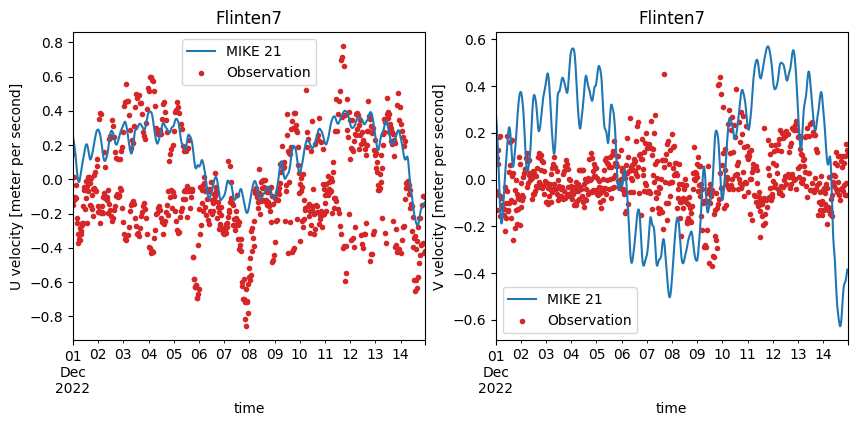

In [21]:
# Look at a timeseries for a qualitative comparison between observations and model
fig,ax=plt.subplots(1,2,figsize=(10,4))
cc_u["Flinten7"].sel(time=slice("2022-12-01","2022-12-14")).plot.timeseries(ax=ax[0])
cc_v["Flinten7"].sel(time=slice("2022-12-01","2022-12-14")).plot.timeseries(ax=ax[1])

## Altimetry data of surface elevations

In [12]:
# Load altimetry data
alt_df = pd.read_csv(f"{root}observations/Altimetry_wl_2014_2024.csv",index_col=0,parse_dates=True)
alt_df

,longitude,latitude,water_level,satellite
datetime,,,,
2014-01-04 16:04:25.036,12.490434,55.498956,-0.036817,j2
2014-01-04 16:04:26.056,12.554527,55.460923,-0.065817,j2
2014-01-04 16:04:27.076,12.618489,55.422852,-0.028817,j2
2014-01-04 16:04:28.096,12.682320,55.384743,-0.014817,j2
2014-01-04 16:04:29.116,12.746020,55.346596,-0.036817,j2
...,...,...,...,...
2023-12-24 10:02:39.000,12.746424,55.334674,0.352183,6a
2023-12-25 04:13:08.994,12.540334,55.332029,-0.013817,sa
2023-12-25 04:13:10.033,12.507634,55.391900,-0.045817,sa


In [13]:
alt_df["satellite"].unique() # Satellite names

array(['j2', 'c2', 'sa', '3a', '3b', '6a'], dtype=object)

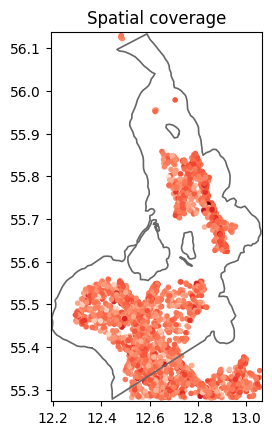

In [14]:
# Define track observation in modelskill
track = modelskill.TrackObservation(alt_df, name="Altimetry", item = 2,x_item=0,y_item=1, quantity=modelskill.Quantity(name="Surface Elevation", unit="meter"))
# Plot overview
modelskill.plotting.spatial_overview(track, mr)
plt.savefig(f"{root}figures/altimetry_coverage.png", bbox_inches='tight')

In [15]:
# Match observations to model results
cmp = modelskill.match(track, mr)
cmp = cmp.remove_bias()

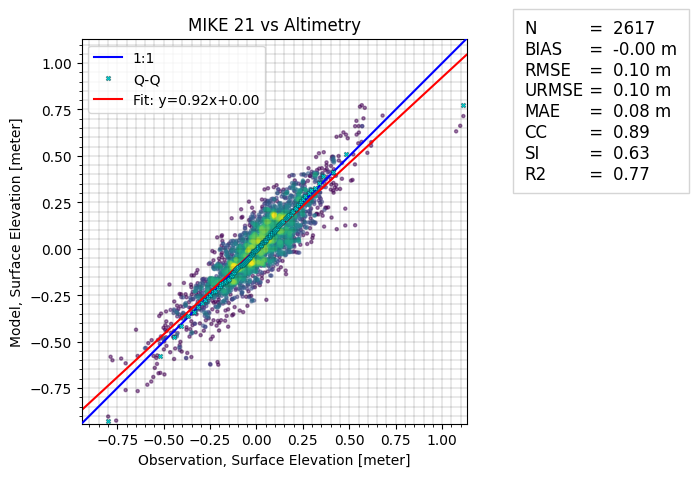

In [16]:
# Do scatter plot
cmp.plot.scatter(skill_table=True,figsize=(6,5));
plt.savefig(f"{root}figures/altimetry_comparison.png", bbox_inches='tight')

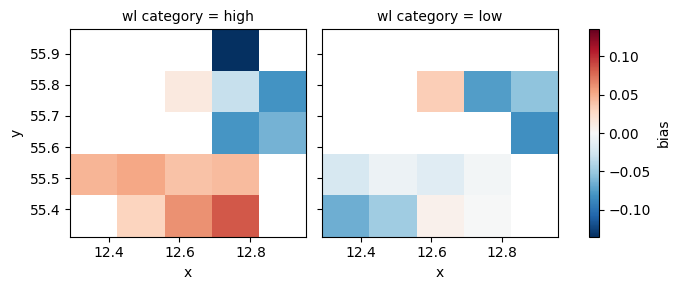

In [17]:
# Plot the bias of the model towards low and high values, respectively
dftmp = cmp.data.to_dataframe()
dftmp["wl category"] = 'high'
dftmp.loc[dftmp['MIKE 21']<0, "wl category"] = 'low'
cmp.data["wl category"] = dftmp["wl category"]
gs = cmp.gridded_skill(by=['wl category'], metrics=['bias'], n_min=5)
gs.bias.plot();